In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

In [2]:
import math

def Rad(d):
    return d * math.pi / 180

def Geodist(point1,point2):
    radLat1 = Rad(point1[1])
    radLat2 = Rad(point2[1])
    delta_lon = Rad(point1[0] - point2[0])
    top_1 = math.cos(radLat2) * math.sin(delta_lon)
    top_2 = math.cos(radLat1) * math.sin(radLat2) - math.sin(radLat1) * math.cos(radLat2) * math.cos(delta_lon)
    top = math.sqrt(top_1 * top_1 + top_2 * top_2)
    bottom = math.sin(radLat1) * math.sin(radLat2) + math.cos(radLat1) * math.cos(radLat2) * math.cos(delta_lon)
    delta_sigma = math.atan2(top, bottom)
    distance = delta_sigma * 6378137.0

    return round(distance,3)

point1=(116.470818,39.927558,0)
point2=(116.470527,39.927338,1)
print(Geodist(point1,point2))

34.884


In [3]:
def get_vertical_dist(pointA,pointB,pointX):
    a=math.fabs(Geodist(pointA,pointB))

    #当弦两端重合时,点到弦的距离变为点间距离
    if a==0:
        return math.fabs(Geodist(pointA,pointX))

    b=math.fabs(Geodist(pointA,pointX))
    c=math.fabs(Geodist(pointB,pointX))
    p=(a+b+c)/2
    S=math.sqrt(math.fabs(p*(p-a)*(p-b)*(p-c)))

    vertical_dist=S*2/a

    return vertical_dist

pointA=(116.470818,39.927558,0)
pointB=(116.470880,39.927403,3149)
pointX=(116.470907,39.927267,10)
print(get_vertical_dist(pointA,pointB,pointX))

2.237216438346514


In [4]:
def DP_compress(point_list,output_point_list,Dmax):
    start_index=0
    end_index=len(point_list)-1

    #起止点必定是关键点,但是作为递归程序此步引入了冗余数据,后期必须去除
    output_point_list.append(point_list[start_index])
    output_point_list.append(point_list[end_index])

    if start_index<end_index:
        index=start_index+1        #工作指针,遍历除起止点外的所有点
        max_vertical_dist=0        #路径中离弦最远的距离
        key_point_index=0        #路径中离弦最远的点,即划分点

        while(index<end_index):
            cur_vertical_dist=get_vertical_dist(point_list[start_index],point_list[end_index],point_list[index])
            if cur_vertical_dist>max_vertical_dist:
                max_vertical_dist=cur_vertical_dist
                key_point_index=index        #记录划分点
            index+=1

        #递归划分路径
        if max_vertical_dist>=Dmax:
            DP_compress(point_list[start_index:key_point_index],output_point_list,Dmax)
            DP_compress(point_list[key_point_index:end_index],output_point_list,Dmax)

In [5]:
def get_MeanErr(point_list,output_point_list):
    Err=0

    start_index=0
    end_index=len(output_point_list)-1

    while(start_index<end_index):        #遍历所有关键点
        #选取两相邻关键点
        pointA_id=int(output_point_list[start_index][2])
        pointB_id=int(output_point_list[start_index+1][2])

        index=pointA_id+1        #工作指针,用于遍历非关键点
        while(index<pointB_id):        #遍历两关键点之间的非关键点
            Err+=get_vertical_dist(output_point_list[start_index],output_point_list[start_index+1],point_list[index])
            index+=1

        start_index+=1

    return Err/len(point_list)

In [7]:
COLUMNS = [ 'time','longitude','latitude']
data = pd.read_excel('qs1/chazhi_1.xlsx', header= None, names= COLUMNS)
ID = pd.Series(data.index, name = 'index')
data = data.drop('time', 1)
data = pd.concat([ID, data], axis = 1)
data.head()

,index,longitude,latitude
0,0,114.205147,30.456370
1,1,114.205162,30.456384
2,2,114.205177,30.456398
3,3,114.205192,30.456412
4,4,114.205208,30.456426


In [8]:
len(data)

59339

In [9]:
point_list=[]
output_point_list=[]

for i in range(len(data)):
    index = int(data.iloc[i][0])
    longitude = data.iloc[i][1]
    latitude = data.iloc[i][2]
    point_list.append((longitude, latitude, index))

DP_compress(point_list,output_point_list,Dmax=15)
output_point_list=list(set(output_point_list))        #去除递归引入的冗余数据
output_point_list=sorted(output_point_list,key=lambda x:x[2])        #按照id排序

In [10]:
len(output_point_list)

206

In [11]:
print("compression rate={}/{}={}".format(len(point_list),len(output_point_list),1 -len(output_point_list)/len(point_list)))
print("mean error:{}".format(get_MeanErr(point_list,output_point_list)))

compression rate=59339/206=0.9965284214428959
mean error:3.9600145403092792


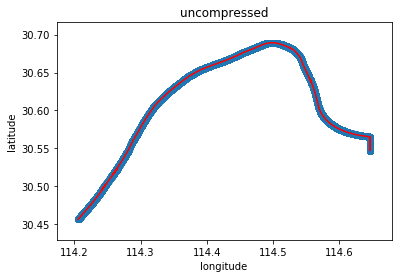

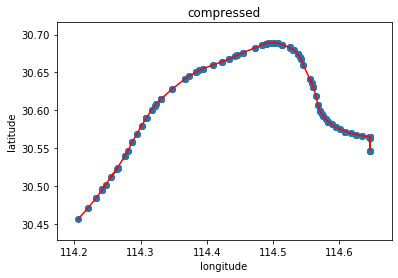

In [12]:
uncompressed=[[],[]]
for point in point_list[:]:
    uncompressed[0].append(point[0])
    uncompressed[1].append(point[1])
    
plt.scatter(uncompressed[0],uncompressed[1])
plt.plot(uncompressed[0], uncompressed[1], 'r')
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.title("uncompressed")
plt.savefig('figure9.jpg')
plt.show()

compressed=[[],[]]
for point in output_point_list:
    compressed[0].append(point[0])
    compressed[1].append(point[1])
    
plt.scatter(compressed[0],compressed[1])
plt.plot(compressed[0], compressed[1], 'r')
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.title("compressed")
plt.savefig('figure10.jpg')
plt.show()

In [13]:
out = np.array(output_point_list)
out = pd.DataFrame(out, columns= ['longitude', 'latitude', 'index'])
out = out.drop('index', 1)
out.head()

,longitude,latitude
0,114.205147,30.456370
1,114.220513,30.471495
2,114.220534,30.471516
3,114.232689,30.484498
4,114.232707,30.484517


In [15]:
out.to_excel('qs1/Compressed_1.xlsx')